In [1]:
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import requests
import time
import xml.etree.ElementTree as ET
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import binomtest
import numpy as np

### multiple testing
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests

import re


### Data

#### PPI

In [2]:
protein_interaction = pd.read_csv('Data/Protein-protein interaction data/9606.protein.links.v12.0.txt', sep= ' ')
protein_interaction_full = pd.read_csv('Data/Protein-protein interaction data/9606.protein.links.full.v12.0.txt', sep= ' ')
protein_interaction_detailed = pd.read_csv('Data/Protein-protein interaction data/9606.protein.links.detailed.v12.0.txt', sep= ' ')
### convert proteins to their true names
protein_info = pd.read_csv('Data/Protein-protein interaction data/9606.protein.info.v12.0.txt', on_bad_lines='skip', sep='\t')
protein_aliases= pd.read_csv('Data/Protein-protein interaction data/9606.protein.aliases.v12.0.txt', on_bad_lines='skip', sep='\t')

In [3]:
### convert proteins to their true names
protein_info = pd.read_csv('Data/Protein-protein interaction data/9606.protein.info.v12.0.txt', on_bad_lines='skip', sep='\t')
protein_aliases= pd.read_csv('Data/Protein-protein interaction data/9606.protein.aliases.v12.0.txt', on_bad_lines='skip', sep='\t')

# Method 1: Using the to_dict() method with 'index' as orient
protein_info_translate_name_dict = protein_info.set_index('#string_protein_id')['preferred_name'].to_dict()
protein_alias_translate_name_dict = protein_aliases.set_index('#string_protein_id')['alias'].to_dict()
#print(protein_info_translate_name_dict)

### Protein1
protein1_name = []
for prot_id in tqdm(protein_interaction['protein1']):
    if prot_id in protein_info_translate_name_dict:
        protein1_name.append(protein_info_translate_name_dict[prot_id])
    elif prot_id in protein_alias_translate_name_dict:
        protein1_name.append(protein_alias_translate_name_dict[prot_id])
    else:
        protein1_name.append('')

### Protein 2
protein2_name = []
for prot_id in tqdm(protein_interaction['protein2']):
    if prot_id in protein_info_translate_name_dict:
        protein2_name.append(protein_info_translate_name_dict[prot_id])
    elif prot_id in protein_alias_translate_name_dict:
        protein2_name.append(protein_alias_translate_name_dict[prot_id])
    else:
        protein2_name.append('')

protein_interaction['Translated_protein_1'] = protein1_name
protein_interaction['Translated_protein_2'] = protein2_name

# Create a set of all (protein1, protein2) pairs
ppi_pairs = set(zip(protein_interaction['Translated_protein_1'], protein_interaction['Translated_protein_2']))
# Check for missing reverse pairs
missing_reverse = []
for a, b in ppi_pairs:
    if (b, a) not in ppi_pairs:
        missing_reverse.append((a, b))

print(f"Number of pairs missing their reverse: {len(missing_reverse)}")
if missing_reverse:
    print("Examples:", missing_reverse[:10])
else:
    print("All pairs have their reverse present.")

100%|██████████| 13715404/13715404 [00:02<00:00, 5235828.26it/s]


Number of pairs missing their reverse: 0
All pairs have their reverse present.


#### DRUGBANK

In [4]:
# import xml.etree.ElementTree as ET

# # Load XML
# drugbank_xml = 'Data/DGIDB/drug_bank.xml'
# tree = ET.parse(drugbank_xml)
# root = tree.getroot()

# # Namespace
# ns = {'db': 'http://www.drugbank.ca'}

# Helper to clean tag names
def clean_tag(tag):
    return tag.split('}')[-1] if '}' in tag else tag

# Recursive function to print structure
def print_structure(elem, level=0):
    indent = '  ' * level
    print(f"{indent}- {clean_tag(elem.tag)}")
    for child in elem:
        print_structure(child, level + 1)

# # Get first drug
# first_drug = root.find('db:drug', ns)

# print("🌿 Structure of First Drug Entry:")
# print_structure(first_drug)
# print("\n🌳 Structure of First 3 Drug Entries:")
# drugs = root.findall('db:drug', ns)

# for i, drug in enumerate(drugs[:3]):
#     print(f"\n🔬 Drug {i+1}:")
#     print_structure(drug)


In [5]:
def structure_drug_bank_data(drug_bank_file = 'Data/DGIDB/drug_bank.xml'):
    """
    Function to structure the drug bank data from the XML file.
    :param drug_bank_file: Path to the drug bank XML file.
    :return: DataFrame containing structured drug bank data.
    """
    ### FYI the .find command only finds the first instance of a tag, 
    ### while .findall retrieves all instances of the specified tag within the current element.

    tree = ET.parse(drug_bank_file)
    root = tree.getroot()

    # DrugBank uses a specific namespace
    ns = {'db': 'http://www.drugbank.ca'}
    ### extract all drug elements
    drugs = root.findall('db:drug', ns)
    print(f"Found {len(drugs)} drugs in the DrugBank XML.")
    # Extract drug-gene interactions
    interactions = []
    # The interactions list will store dictionaries with 'drug' and 'gene' keys.
    for drug in root.findall('db:drug', ns): # root.findall('db:drug', ns): Finds all <drug> elements using the namespace.
        drug_name  = drug.find('db:name', ns).text  # drug.find('db:name', ns): Gets the drug's name.
        # print(drug_name)
        for target in drug.findall('db:targets/db:target', ns):  # drug.findall('db:targets/db:target', ns): Finds all <target> elements within <targets>.
            # print(target.tag)
            gene_description = target.find('db:name', ns)  # target.find('db:name', ns): Extracts the gene name for each target.
            poly = target.find('db:polypeptide', ns)  # target.find('db:polypeptide', ns): Extracts the polypeptide information.
            action = target.find('db:actions/db:action', ns) # target.find('db:actions/db:action', ns): Extracts the action of the drug on the target.
            if poly is not None:
                poly_name = poly.find('db:name', ns)
                gene_name = poly.find('db:gene-name', ns)
                specific_function = poly.find('db:specific-function', ns)
                interactions.append({
                    'drug': drug_name,
                    'polypeptide': poly_name.text if poly_name is not None else None,
                    'gene': gene_name.text if gene_name is not None else None,
                    'gene_description': gene_description.text if gene_description is not None else None,
                    'action': action.text if action is not None else None,
                    'specific_function': specific_function.text if specific_function is not None else None
                })
            ############# if polypeptide is not present, we still want to add the drug and gene information
            ############# this is because some drugs may not have a polypeptide associated with them
            ############# but we still want to capture the drug and gene information
            ############# this is common in the DrugBank database, where some drugs target genes directly
            ############# and do not have a polypeptide associated with them

            else:
                gene_name = None
                specific_function = None
                poly_name = None
                action = None
                gene_description = None
                resource = None
                identifier = None
  
                interactions.append({
                        'drug': drug_name,
                        'polypeptide': poly_name.text if poly_name is not None else None,
                        'gene': gene_name.text if gene_name is not None else None,
                        'gene_description': gene_description.text if gene_description is not None else None,
                        'action': action.text if action is not None else None,
                        'specific_function': specific_function.text if specific_function is not None else None
                    })
        
    # Convert to DataFrame
    # Converts the list of dictionaries into a pandas DataFrame, which is easier to analyze, filter, and export.
    df = pd.DataFrame(interactions)

    return df

In [6]:
Drug_bank = structure_drug_bank_data('Data/DRUGBANK/drug_bank.xml')

Found 17430 drugs in the DrugBank XML.


In [7]:
print(f"{len(set(Drug_bank['drug']))} unique drugs found in DrugBank.")
print(f"{len(set(Drug_bank['gene']))} unique genes found in DrugBank.")
print(f"{len(set(tuple(Drug_bank['drug'] + Drug_bank['gene'])))} unique drug-gene pairs found in DrugBank.")
print(f"{len(Drug_bank)} size of DrugBank interactions found in DrugBank.")

9368 unique drugs found in DrugBank.
4187 unique genes found in DrugBank.
21714 unique drug-gene pairs found in DrugBank.
23136 size of DrugBank interactions found in DrugBank.


#### Literature Data

In [8]:
scraped_lit_data = pd.read_csv('Data/extracted_targets_all_pub_after_2000_GPU_2b_gemma.csv', on_bad_lines='skip')

### Results

In [9]:
scraped_lit_data

,Unnamed: 0.1,Unnamed: 0,PMID,TITLE,YEAR,ABSTRACT,TARGETS,SENTENCE_WHERE_FOUND
0,108358,108358,9166454,Thymidylate synthase protein expression: Assoc...,2006.0,PURPOSE:A phase II study of neoadjuvant fluoro...,"total thymidylate synthase, free thymidylate s...","""the pretreatment total thymidylate synthase l..."
1,108359,108359,9166473,The standard to come: systemic therapies for s...,2006.0,No abstract available,no information available,the abstract did not contain any information r...
2,108360,108360,9166480,Final report of a phase II study of chemothera...,2006.0,PURPOSE:This article presents an assessment of...,- bleomycin - epirubicin - cisplatin sentence...,NaN
3,108361,108361,9166498,High-dose cisplatin as neoadjuvant organ-prese...,2006.0,PURPOSE:We conducted this study to evaluate th...,none,not provided in the context.<eos>
4,108362,108362,9166522,Practice guidelines for esophageal cancer.,2006.0,No abstract available,no information available,the abstract did not contain any information r...
...,...,...,...,...,...,...,...,...
62184,406528,406528,39138492,The spatial distribution of intermediate fibro...,2024.0,BACKGROUND:Oral cancer poses a significant hea...,"fn1, col5a1",results showed that the tumor-stromal interfac...
62185,406529,406529,39138513,A nomogram based on circulating CD8,2024.0,PURPOSE:To explore the influence of circulatin...,circulating cd8,the circulating cd8 protein is a surface marke...
62186,406530,406530,39138528,Spindle epithelial tumor with thymus-like elem...,2024.0,Spindle epithelial tumor with thymus-like elem...,p16 immunoexpression,"""diffuse and strong p16 immunoexpression has n..."
62187,406531,406531,39138540,DNA methylation markers for oral cancer detect...,2024.0,More than 50% of oral cancer (OC) patients are...,no information available,the abstract did not contain information relat...


In [10]:
### statistics
print("Number of unique PMIDs in scraped literature data: ", scraped_lit_data['PMID'].nunique())
print("Number of unique abstracts in scraped literature data: ", scraped_lit_data['ABSTRACT'].nunique())
print("Number of unique targets in scraped literature data: ", scraped_lit_data['TARGETS'].nunique())

Number of unique PMIDs in scraped literature data:  62189
Number of unique abstracts in scraped literature data:  48339
Number of unique targets in scraped literature data:  32486


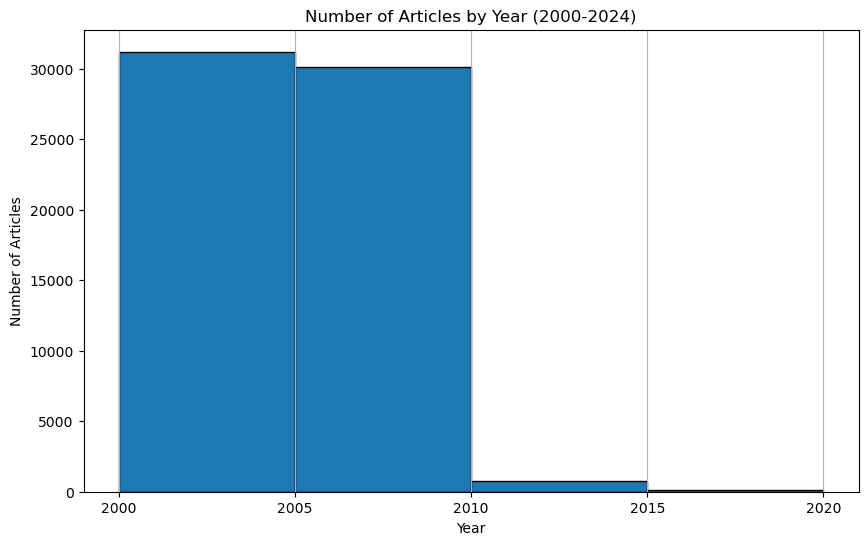

In [11]:
### plot histogram of articles by 5 year bins histogram
scraped_lit_data['YEAR'] = pd.to_numeric(scraped_lit_data['YEAR'], errors='coerce')
scraped_lit_data['YEAR'] = scraped_lit_data['YEAR'].fillna(0)  # Fill NaN with 0
scraped_lit_data['YEAR'] = scraped_lit_data['YEAR'].astype(int)
# scraped_lit_data['YEAR'] = scraped_lit_data['YEAR'].astype(str)
plt.figure(figsize=(10, 6))
scraped_lit_data['YEAR'].hist(bins=range(2000, 2025, 5), edgecolor='black')
plt.title('Number of Articles by Year (2000-2024)')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.xticks(range(2000, 2025, 5))
plt.grid(axis='y')
plt.show()

In [12]:
### Function to keep valid genes
def keep_valid_genes(df, gene_col="GENE"):
    """
    Cleans gene extraction table:
    1. Removes placeholder/unknown texts.
    2. Normalizes whitespace.
    3. Keeps valid gene symbols:
       - Standard genes: letters/digits, optional hyphen (e.g., EGFR, HLA-DQA1)
       - miRNAs: miR-21, let-7b
    """
    
    # known unknown/placeholder texts
    notavailable_texts = [
        'NO INFORMATION AVAILABLE', 'THERE IS NO INFORMATION AVAILABLE', 'NO INFORMATION AVAILABLE.',
        'no information available', 'UNKNOWN', 'NONE', 'NOT PROVIDED IN THE ABSTRACT',
        'THEREFORE I CANNOT EXTRACT THE REQUESTED INFORMATION FROM THE CONTEXT.',
        'NOT MENTIONED IN THE ABSTRACT', 'SO I CANNOT EXTRACT THE REQUESTED INFORMATION FROM THE CONTEXT.',
        'THEREFORE I CANNOT EXTRACT THE TARGETS FROM THIS ABSTRACT', 'THEREFORE',
        'NO INFORMATION IS AVAILABLE.'
    ]
    # lowercase for uniform matching
    notavailable_texts = set([text.lower() for text in notavailable_texts])
    # normalize gene text

    
    df[gene_col] = df[gene_col].astype(str).str.strip()
    # remove unknowns/placeholders
    df = df[~df[gene_col].str.lower().isin(notavailable_texts)]
    
    # compile regex for valid genes (case-insensitive)
    gene_pattern = re.compile(
        r'^(?:[A-Z0-9]{2,12}(?:-[A-Z0-9]{1,6})?|miR-\d+[a-z]?|let-\d+[a-z]?)$',
        flags=re.IGNORECASE
    )
    
    # keep only valid gene symbols
    mask = df[gene_col].str.match(gene_pattern)
    return df[mask]


In [13]:
### Extract targets, number of targets per article, and indexes of the articles
raw_targets = list(scraped_lit_data['TARGETS'])
data_rows = []
for i, target_raw in tqdm(enumerate(raw_targets)):
    try:
        targets = target_raw.split(',')
        for val in targets:
            gene_val = str.lower(val.strip())
            data_rows.append({
                'GENE': gene_val,
                'PMID': scraped_lit_data.iloc[i]['PMID'],
                'INDEX': i
            })
    except:
        gene_val = str(target_raw)
        data_rows.append({
            'GENE': gene_val,
            'PMID': scraped_lit_data.iloc[i]['PMID'],
            'INDEX': i
        })
        continue

extracted_target_df = pd.DataFrame(data_rows)

### This will count the number of articles for each gene,
### and add a new column 'NUMBER_OF_ARTICLES' to the DataFrame
## .groupby('GENE') groups the DataFrame by the 'GENE' column
## .transform('count') counts the number of occurrences of each gene
extracted_target_df['NUMBER_OF_ARTICLES'] = extracted_target_df.groupby('GENE')['PMID'].transform('nunique')

62189it [00:01, 44016.77it/s]


In [14]:
### Summary of Scraped Literature Data
print('---- Raw data -----')
print(f'Number of articles after scraping raw literature data: {extracted_target_df["PMID"].nunique()}')
print(f'Number of unique genes after scraping raw literature data: {extracted_target_df["GENE"].nunique()}')

---- Raw data -----
Number of articles after scraping raw literature data: 62189
Number of unique genes after scraping raw literature data: 47939


In [15]:
extracted_target_df

,GENE,PMID,INDEX,NUMBER_OF_ARTICLES
0,total thymidylate synthase,9166454,0,1
1,free thymidylate synthase,9166454,0,1
2,bound thymidylate synthase,9166454,0,1
3,no information available,9166473,1,15372
4,- bleomycin - epirubicin - cisplatin sentence...,9166480,2,1
...,...,...,...,...
102565,klk4,39139739,62188,1
102566,rtbdn,39139739,62188,1
102567,tenm1,39139739,62188,1
102568,gdf15,39139739,62188,1


In [16]:
### print stats
print(f"Total number of unique articles: {len(set(extracted_target_df['PMID']))}")
print(f"Total number of unique genes: {len(set(extracted_target_df['GENE']))}")

Total number of unique articles: 62189
Total number of unique genes: 47939


In [17]:
extracted_target_df = keep_valid_genes(extracted_target_df)

In [18]:
extracted_target_df

,GENE,PMID,INDEX,NUMBER_OF_ARTICLES
23,icam-1,9834364,15,14
26,int2,9858651,18,2
27,erbb-2,9858651,18,6
38,tag-72,10702789,27,1
46,lung,10849547,34,66
...,...,...,...,...
102564,mmp12,39139739,62188,2
102565,klk4,39139739,62188,1
102566,rtbdn,39139739,62188,1
102567,tenm1,39139739,62188,1


In [19]:
print('---- Cleaned data -----')
print(f'Number of articles after cleaning: {extracted_target_df["PMID"].nunique()}')
print(f'Number of unique genes after cleaning: {extracted_target_df["GENE"].nunique()}')

---- Cleaned data -----
Number of articles after cleaning: 10390
Number of unique genes after cleaning: 6077


In [20]:
extracted_target_df.to_csv('Results/cleaned_extracted_targets_all_pub_after_2000_GPU_2b_gemma.csv', index=False)

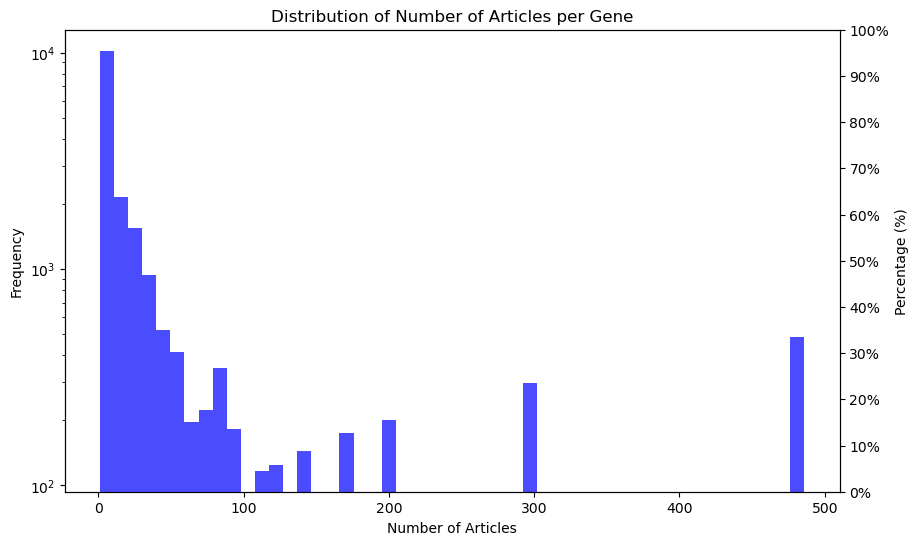

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(extracted_target_df['NUMBER_OF_ARTICLES'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Number of Articles per Gene')
plt.xlabel('Number of Articles')
plt.ylabel('Frequency')
### may y axis log
plt.yscale('log')
### percentage axis
plt.twinx()
plt.yticks(range(0, 101, 10), [f'{i}%' for i in range(0, 101, 10)])
plt.ylabel('Percentage (%)')

plt.show()

In [22]:
### combine the PMID and index into one row per gene seperated by a comma
extracted_target_df_combined = extracted_target_df.groupby('GENE').agg({
    'PMID': lambda x: ', '.join(x.astype(str)),
    'INDEX': lambda x: ', '.join(x.astype(str)),
    'NUMBER_OF_ARTICLES': 'first'
}).reset_index()
extracted_target_df_combined['GENE'] = extracted_target_df_combined['GENE'].str.upper()

In [23]:
extracted_target_df_combined

,GENE,PMID,INDEX,NUMBER_OF_ARTICLES
0,000-2,"11302242, 11302242","2610, 2610",1
1,10,"12608845, 12768769, 14967420, 15193028, 180565...","15288, 17016, 27005, 29481, 57658, 61105",6
2,106PRE,18186293,58737,1
3,106R,18186293,58737,1
4,106RECR,18186293,58737,1
...,...,...,...,...
6072,ZP-V3,12464647,13458,1
6073,ZP-V4,12464647,13458,1
6074,ZYGOMA,15883929,36459,1
6075,ZYGOMATIC,"12775236, 17522494","17081, 53057",2


In [24]:
extracted_target_df_combined.to_csv('Results/cleaned_extracted_combined_targets_all_pub_after_2000_GPU_2b_gemma.csv', index=False)

In [25]:
### isolate to geenes that are in drug bank or ppi
drug_bank_genes = set(Drug_bank['gene'].dropna().str.upper())
ppi_genes = set(protein_interaction['Translated_protein_1'].dropna().str.upper()).union(
    set(protein_interaction['Translated_protein_2'].dropna().str.upper())
)
### create list combining both
valid_genes = drug_bank_genes.union(ppi_genes)

### top genes from extracted
extracted_target_df_combined_top = extracted_target_df_combined[extracted_target_df_combined['GENE'].isin(valid_genes)]

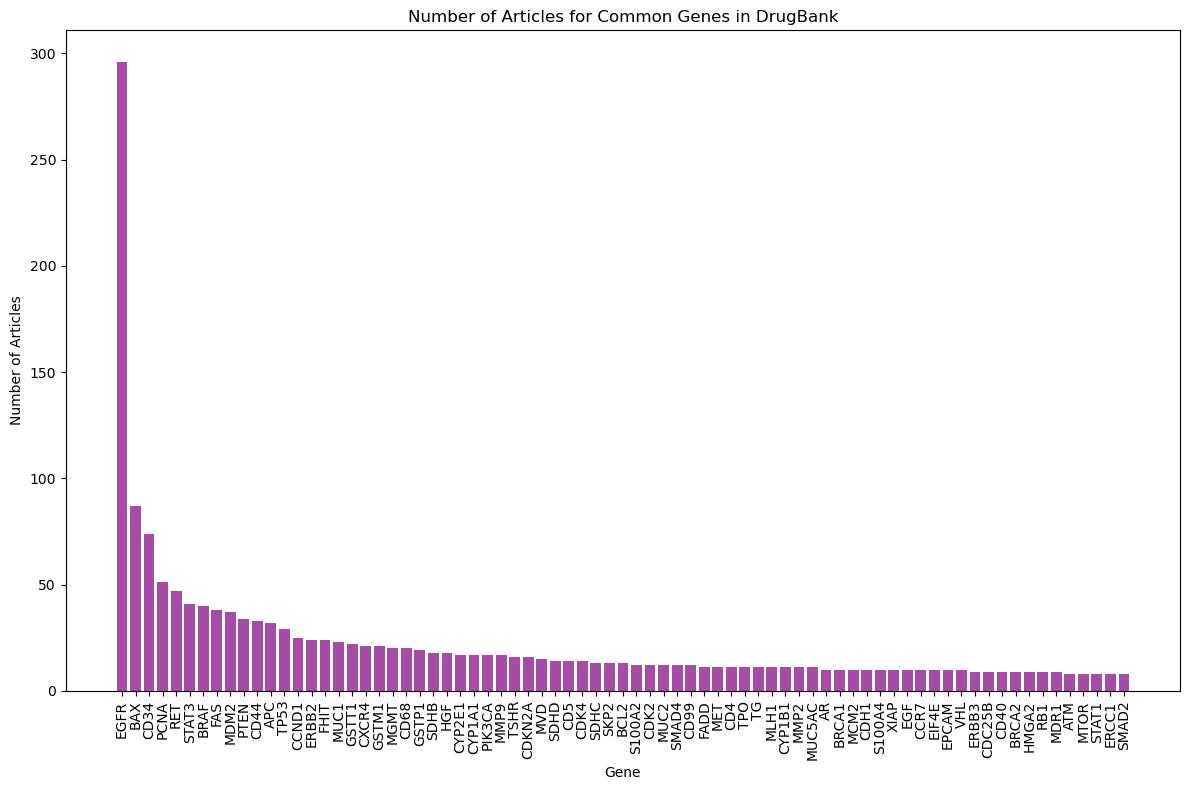

In [26]:
### plot gene vs number of articles from common genes for the top 100 genes
extracted_target_df_combined_top = extracted_target_df_combined_top.sort_values(by='NUMBER_OF_ARTICLES', ascending=False)
top_100_common_genes = extracted_target_df_combined_top.head(75)
plt.figure(figsize=(12, 8))
plt.bar(top_100_common_genes['GENE'], top_100_common_genes['NUMBER_OF_ARTICLES'], color='purple', alpha=0.7)
plt.title('Number of Articles for Common Genes in DrugBank')
plt.xlabel('Gene')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()